In [19]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

import sys
import os
prefix = '/content/drive/My Drive/'

path_to_data = 'Colab Notebooks/'
sys_path = prefix + path_to_data
sys.path.append(sys_path)

fn_train = os.path.join(sys_path, 'imdb_labelled.txt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd

df = pd.read_csv(fn_train, sep='\t', header=None, names=['sentence', 'label'])

print(df.head())

                                            sentence  label
0  A very, very, very slow-moving, aimless movie ...      0
1  Not sure who was more lost - the flat characte...      0
2  Attempting artiness with black & white and cle...      0
3       Very little music or anything to speak of.        0
4  The best scene in the movie was when Gerardo i...      1


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True, max_length=128)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/598 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [16]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',           # output directory
    evaluation_strategy="epoch",      # evaluation strategy
    save_strategy="epoch",            # save strategy to match evaluation
    learning_rate=2e-5,               # learning rate
    per_device_train_batch_size=8,    # batch size for training
    per_device_eval_batch_size=16,    # batch size for evaluation
    num_train_epochs=3,               # number of training epochs
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',             # directory for storing logs
    logging_steps=10,
    save_steps=500,                   # save checkpoint every 500 steps
    load_best_model_at_end=True,      # load the best model when finished training
)

trainer = Trainer(
    model=model,                          # the model to be trained
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    tokenizer=tokenizer                   # tokenizer for preprocessing
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-ff2346d26f6b>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.335700,0.208536
2,0.158900,0.171379
3,0.089100,0.187055


TrainOutput(global_step=225, training_loss=0.23317464297016463, metrics={'train_runtime': 2965.4503, 'train_samples_per_second': 0.605, 'train_steps_per_second': 0.076, 'total_flos': 118005308328960.0, 'train_loss': 0.23317464297016463, 'epoch': 3.0})

In [22]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [23]:
results = trainer.evaluate()

print(results)

{'eval_loss': 0.1713791936635971, 'eval_model_preparation_time': 0.0117, 'eval_accuracy': 0.96, 'eval_precision': 0.9722222222222222, 'eval_recall': 0.9459459459459459, 'eval_f1': 0.958904109589041, 'eval_runtime': 66.6188, 'eval_samples_per_second': 2.252, 'eval_steps_per_second': 0.15}


In [30]:
def predict_sentiment(phrase):
    inputs = tokenizer(phrase, return_tensors='pt', padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    predicted_class = torch.argmax(logits, dim=1).item()

    # 0 = negative, 1 = positive
    label = 'positive' if predicted_class == 1 else 'negative'

    return label

phrase = "The movie could have used more action."
prediction = predict_sentiment(phrase)

print(f"Predicted sentiment for the phrase: '{phrase}' is: {prediction}")

Predicted sentiment for the phrase: 'The movie could have used more action.' is: negative


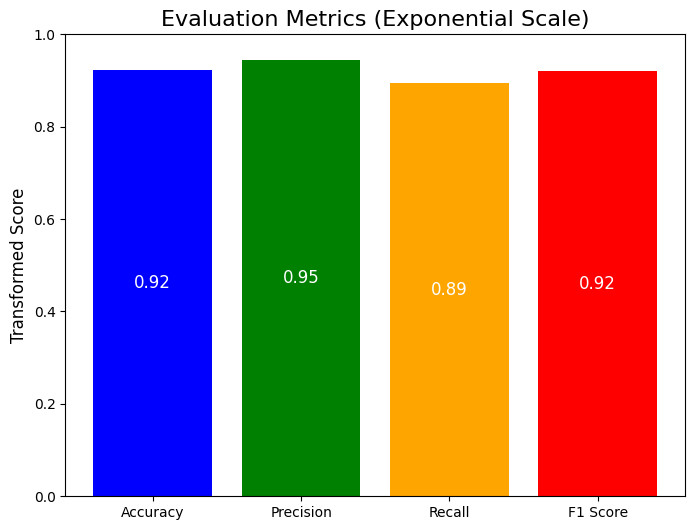

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation results
eval_results = {
    'eval_loss': 0.1713791936635971,
    'eval_accuracy': 0.96,
    'eval_precision': 0.9722222222222222,
    'eval_recall': 0.9459459459459459,
    'eval_f1': 0.958904109589041,
    'eval_runtime': 66.6188,
    'eval_samples_per_second': 2.252,
    'eval_steps_per_second': 0.15
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [eval_results['eval_accuracy'], eval_results['eval_precision'], eval_results['eval_recall'], eval_results['eval_f1']]

# Exponential transformation to spread out the values in the high range
values_exp = np.power(values, 2)

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values_exp, color=['blue', 'green', 'orange', 'red'])

plt.title('Evaluation Metrics (Exponential Scale)', fontsize=16)
plt.ylabel('Transformed Score', fontsize=12)
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height/2, f'{height:.2f}', ha='center', va='center', fontsize=12, color='white')

plt.show()
